In [14]:
!git clone https://github.com/vebrahimi1990/WideField_Denoising.git

fatal: destination path 'WideField_Denoising' already exists and is not an empty directory.


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
import matplotlib.pyplot as plt

In [16]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [17]:
from WideField_Denoising import  loss_2D, datagenerator_2D, Model_2D_Unet

data_generator = datagenerator_2D.data_generator
make_generator = Model_2D_RCAN.make_generator
generator_loss = loss_2D.generator_loss

In [24]:
patch_size = 256
n_patches =  8
channel_n =  0


augment = False
shuffle = True
add_noise= True
l_poisson = 1.0

threshold = 0.2
ratio = 1.0

GT_image_dr = r'D:\Models\Data generator\STED-Histon_Microtubule_Crossmodality\fast sted\train\Average.tif'
lowSNR_image_dr =r'D:\Models\Data generator\STED-Histon_Microtubule_Crossmodality\fast sted\train\1frame.tif'

x_train, y_train, x_valid, y_valid = data_generator(GT_image_dr, lowSNR_image_dr, patch_size, n_patches,
                                                    n_channel=channel_n, threshold=threshold,ratio=ratio,lp=l_poisson,
                                                    augment=augment,shuffle=shuffle,add_noise=add_noise)

(17, 2, 2048, 2048)
832
The training set shape is: (832, 256, 256, 1)
The validation set shape is: (0, 256, 256, 1)


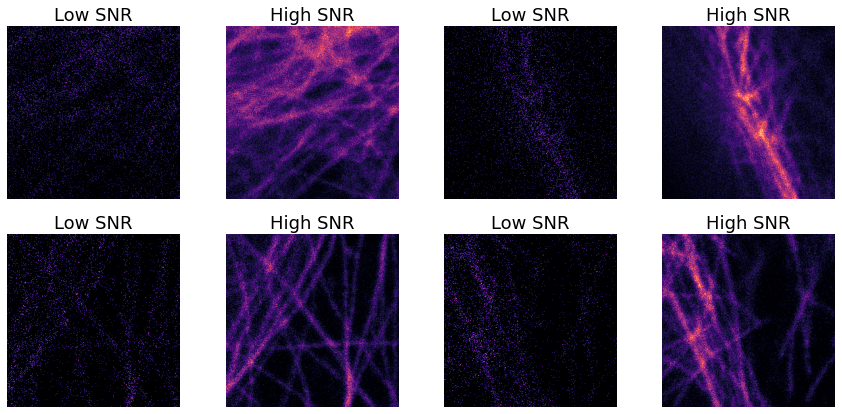

In [25]:
ix = np.random.randint(0,len(x_train),4)
fig = plt.figure(figsize=(15,7))

for i in range(4):
    norm_x = np.linalg.norm(x_train[ix[i]], axis=(0, 1))
    fig.add_subplot(2,4, 2*i+1)
    cmap=plt.get_cmap('magma')
    plt.imshow(x_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('Low SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')
    
    fig.add_subplot(2,4, 2*i+2)
    cmap=plt.get_cmap('magma')
    plt.imshow(y_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('High SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

In [26]:
filters =[32,64,128]

num_filters = filters[0]
r = 8
filters_cab=num_filters/r
num_RG=4
num_RCAB=5

generator_input = Input((patch_size, patch_size,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB,
                           kernel_shape=3,dropout=0.2)

In [27]:
model_save_directory = r"D:\Models\Data generator\STED-Histon_Microtubule_Crossmodality\fast sted\train\microtubule_rcan_test.h5" 
n_epochs =  10
gen_lr = 1e-4
batch_size = 1

gen_opt = keras.optimizers.Adam(learning_rate=gen_lr)
generator.compile(optimizer=gen_opt, loss='mse')

callbacks = [
    EarlyStopping(patience=50, verbose=1),
    ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5),
    ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

In [28]:
# load_model_directory = r"D:\Projects\Denoising-STED\20220913-RPI\STED power dependence\tubulin\tubulin_STED70.h5" 
# generator.load_weights(load_save_directory)

In [29]:
results = generator.fit(x=x_train,y=y_train, batch_size=batch_size, epochs=n_epochs,verbose=1,
                        callbacks=callbacks,validation_split=0.1)

Epoch 1/10
747/748 [============================>.] - ETA: 0s - loss: 0.0040
Epoch 00001: val_loss improved from inf to 0.00327, saving model to D:\Models\Data generator\STED-Histon_Microtubule_Crossmodality\fast sted\train\microtubule_rcan_test.h5
748/748 [==============================] - 19s 19ms/step - loss: 0.0040 - val_loss: 0.0033 - lr: 1.0000e-04
Epoch 2/10
748/748 [==============================] - ETA: 0s - loss: 0.0031
Epoch 00002: val_loss improved from 0.00327 to 0.00318, saving model to D:\Models\Data generator\STED-Histon_Microtubule_Crossmodality\fast sted\train\microtubule_rcan_test.h5
748/748 [==============================] - 14s 19ms/step - loss: 0.0031 - val_loss: 0.0032 - lr: 1.0000e-04
Epoch 3/10
748/748 [==============================] - ETA: 0s - loss: 0.0031
Epoch 00003: val_loss improved from 0.00318 to 0.00314, saving model to D:\Models\Data generator\STED-Histon_Microtubule_Crossmodality\fast sted\train\microtubule_rcan_test.h5
748/748 [====================